### 코드 참조
https://huggingface.co/transformers/v3.2.0/custom_datasets.html


https://github.com/skandavivek/fine-tune-transformer-classifier/blob/main/sequence_classification_blog.ipynb

### wandb 참조
https://docs.wandb.ai/guides/integrations/huggingface


In [2]:
path = "/content/drive/MyDrive/Colab_Notebooks/Huggingface"

In [51]:
import pandas as pd

dftrain = pd.read_csv(path+"/data/clickbait/train.csv")
dftrain = dftrain.drop(columns='Unnamed: 0')
dftrain

,sample,clickbait
0,Sixteen Christian converts arrested in Iran; f...,no
1,Hiring of Isiah Thomas Angers Some F.I.U. Facu...,no
2,Fußball-Bundesliga 2007–08: Matchday 1 roundup,no
3,Taco Bell mascot Gidget dies from stroke at 15,no
4,China Takes Heavy Criticism Over Software Dire...,no
...,...,...
26995,Which Italian City Should You Live In,yes
26996,Chelsea signs Essien for £26 million,no
26997,Which Dessert Pastry Matches Your Zodiac Sign,yes
26998,"Aid, and Perhaps More, Spreading in Myanmar Delta",no


<Axes: xlabel='clickbait'>

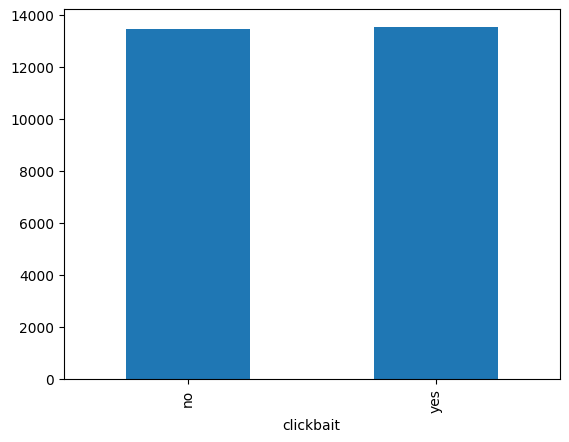

In [31]:
dftrainplot=dftrain.groupby(['clickbait']).size()
dftrainplot.plot(kind='bar')

In [52]:
dftest = pd.read_csv(path+"/data/clickbait/test.csv")
dftest = dftest.drop(columns='Unnamed: 0')
dftest

,sample,clickbait
0,Food Brands Compete to Stretch Your Buck,no
1,22 Things You'll Understand If You're Slightly...,yes
2,23 Times Shah Rukh Khan Was The Cutest Dad Ever,yes
3,Hilary Duff Chopped Off Her Hair And Now You'r...,yes
4,"Film Channel Has Name, but No Network Carrier",no
...,...,...
1995,15 Years Ago Rob Lowe Looked Exactly The Same ...,yes
1996,"US, UK embassies in Yemen close due to al-Qaed...",no
1997,Here Are 16 Truly Useful Tools For Beginner Cooks,yes
1998,22 Deep Questions To Ponder In 2016,yes


<Axes: xlabel='clickbait'>

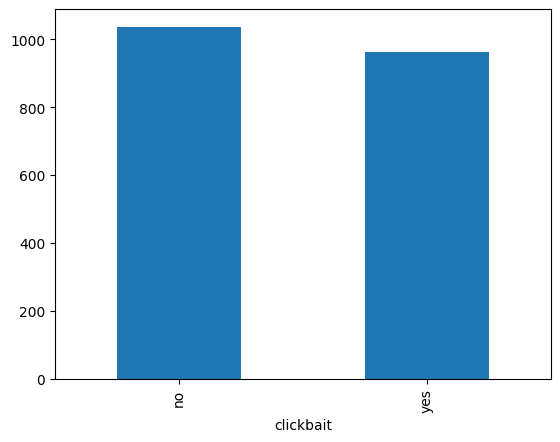

In [33]:
dftestplot=dftest.groupby(['clickbait']).size()
dftestplot.plot(kind='bar')

<Axes: xlabel='clickbait'>

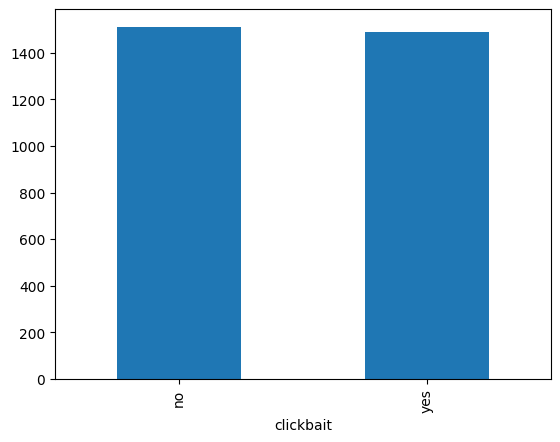

In [20]:
dfval = pd.read_csv(path+"/data/clickbait/validation.csv")
dfval = dfval.drop(columns='Unnamed: 0')
dfval=dfval.groupby(['clickbait']).size()
dfval.plot(kind='bar')

In [ ]:
# val이 이미 나눠져있으므로 필요없음.
# from sklearn.model_selection import train_test_split
# train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

## Tokenizer

new

In [7]:
!pip install torchsampler transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.1 MB/s eta 0:00:00


In [8]:
import transformers
from datasets import load_dataset
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data import DataLoader
from transformers import AutoModel, AdamW


# Text Classification

load_dataset function

In [9]:
from datasets import load_dataset
import pandas as pd

In [53]:
dftrain = dftrain[['sample','clickbait']]
dftrain.columns = ['text','label']
dftrain.loc[dftrain['label']=='no', 'label'] =0
dftrain.loc[dftrain['label']=='yes', 'label']=1

dftest = dftest[['sample','clickbait']]
dftest.columns = ['text','label']
dftest.loc[dftest['label']=='no', 'label'] =0
dftest.loc[dftest['label']=='yes', 'label']=1

dftrain.to_csv(path+'/data/clickbait/df_train.csv',index=False)
dftest.to_csv(path+'/data/clickbait/df_test.csv',index=False)

dataset = load_dataset('csv', data_files = {'train':path+"/data/clickbait/df_train.csv",
                                            'test' : path+"/data/clickbait/df_test.csv"})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b4237ed552acfa71/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [45]:
dftrain

,text,label
0,Sixteen Christian converts arrested in Iran; f...,0
1,Hiring of Isiah Thomas Angers Some F.I.U. Facu...,0
2,Fußball-Bundesliga 2007–08: Matchday 1 roundup,0
3,Taco Bell mascot Gidget dies from stroke at 15,0
4,China Takes Heavy Criticism Over Software Dire...,0
...,...,...
26995,Which Italian City Should You Live In,1
26996,Chelsea signs Essien for £26 million,0
26997,Which Dessert Pastry Matches Your Zodiac Sign,1
26998,"Aid, and Perhaps More, Spreading in Myanmar Delta",0


load BERT tokenizer to preprocess the text data

In [54]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [55]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [56]:
def preprocess_function(examples):
  return tokenizer(examples["text"], truncation=True, padding=True)

In [57]:
tokenized_data = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/27000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [58]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### W&B logging

In [70]:
!pip install wandb

import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=f860a5dfa3b5fb1f8789a26809e2e1bfc95905abe9c3943e48a3fbded553f6fb
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [71]:
%env WANDB_PROJECT = Clickbait_classifier

env: WANDB_PROJECT=Clickbait_classifier


### Training the model

In [59]:
id2label = {0:"no", 1:"yes"}
label2id = {"no":0, "yes":1}

In [73]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels= 2, id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    output_dir = "clickbait-classifier",
    learning_rate= 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs=5,
    weight_decay = 0.01,
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb", # enable logging to W&B
    run_name = 'bert-base-uncased-cbc', # name of the W&B run (optional)
    # push_to_hub= True,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [74]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds= pred.predictions.argmax(-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds,average = 'binary')
  acc = accuracy_score(labels, preds)
  auc = roc_auc_score(labels, preds)
  return {
      'accuracy': acc,
      'f1' : f1,
      'precision' : precision,
      'recall' : recall,
      'auroc' : auc
  }

In [76]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset = tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics = compute_metrics,
)

In [77]:
trainer.train()
wandb.finish()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


wandb: Currently logged in as: arsol970812. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auroc
1,0.051000,0.099543,0.978500,0.978072,0.960922,0.995846,0.979119
2,0.014600,0.055889,0.991000,0.990683,0.987616,0.993769,0.991099
3,0.006300,0.075239,0.988000,0.987603,0.982528,0.992731,0.988169
4,0.001500,0.074767,0.989000,0.988613,0.985552,0.991693,0.989096
5,0.000000,0.076286,0.990500,0.990140,0.989627,0.990654,0.990506


eval/accuracy,▁█▆▇█
eval/auroc,▁█▆▇█
eval/f1,▁█▆▇█
eval/loss,█▁▄▄▄
eval/precision,▁█▆▇█
eval/recall,█▅▄▂▁
eval/runtime,▂██▁▃
eval/samples_per_second,▇▁▁█▆
eval/steps_per_second,▇▁▁█▆
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▆▆▇▇▇███
train/global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▆▆▇▇▇███


In [78]:
trainer.save_model(path)

In [ ]:
trainer.state.log_history()